In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv('features_mine_mfcc_energy_mel_train_padding_split.csv')
val_df = pd.read_csv('features_mine_mfcc_energy_mel_val_padding_split.csv')

In [3]:
def preprocess_data(df, fit_scalers=None):
    """Reshapes and normalizes data for LSTM input.

    Args:
        df (DataFrame): Input DataFrame where each 3 rows = 1 clip.
        fit_scalers (list of scalers): Optional. If given, reuse these scalers.

    Returns:
        X: (num_clips, 200, 3) normalized feature array
        y: label-encoded targets
        classes: class names (only for first call)
        scalers: fitted scalers (only for first call)
    """
    # 1. Extract labels (1 per clip, every 3 rows)
    labels = df['labels'].iloc[::3].values
    le = LabelEncoder()
    y = le.fit_transform(labels)

    # 2. Extract feature data and reshape
    feature_data = df.drop(columns=['labels']).values
    num_clips = len(df) // 3
    reshaped = feature_data.reshape(num_clips, 3, -1)  # shape: (num_clips, 3, 200)

    # 3. Normalize each feature across all clips and time steps
    normalized = np.empty_like(reshaped, dtype=np.float32)
    scalers = []

    for i in range(3):  # For each feature
        feature_i = reshaped[:, i, :].reshape(-1, 1)  # shape: (num_clips*200, 1)

        if fit_scalers:  # Use existing scaler
            normalized_feature = fit_scalers[i].transform(feature_i)
        else:  # Fit new scaler
            scaler = StandardScaler()
            normalized_feature = scaler.fit_transform(feature_i)
            scalers.append(scaler)

        # Reshape back to (num_clips, 200)
        normalized[:, i, :] = normalized_feature.reshape(num_clips, -1)

    # 4. Transpose to (num_clips, 200, 3) → for LSTM: (samples, timesteps, features)
    X = normalized.transpose(0, 2, 1)

    if fit_scalers is None:
        return X, y, le.classes_, scalers
    else:
        return X, y, le.classes_

In [4]:
# 1. Process TRAIN data and get fitted scalers
X_train, y_train, class_names, scalers = preprocess_data(train_df)

# 2. Process VAL/TEST data with TRAIN scalers
X_val, y_val, _ = preprocess_data(val_df, fit_scalers=scalers)
#X_test, y_test, _ = preprocess_data(test_df, fit_scalers=scalers)

In [5]:
def evaluate_model(model, X_val, y_val):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print("Accuracy:", acc)
    print("F1 Score (macro):", f1)
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    return acc, f1

In [6]:
def plot_conf_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


In [7]:
time_steps = 200
num_features = 3  

In [28]:
# ==== Default Hyperparameters ====
INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 128
DROPOUT_RATE = 0.2
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.005
PROJECTION_DIM = 32
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

In [29]:
def build_and_train_LSTM_model(model_name,input_shape=INPUT_SHAPE,lstm_units=LSTM_UNITS,dense_units=DENSE_UNITS,num_classes=NUM_CLASSES,epochs=EPOCHS ,dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,loss_function=LOSS_FUNCTION, optimizer=OPTIMIZER,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,projection_dim=PROJECTION_DIM):
    
    model = Sequential([
        TimeDistributed(Dense(projection_dim, activation='linear'), input_shape=(input_shape)),
        LSTM(lstm_units, return_sequences=True),
        LSTM(lstm_units, return_sequences=False),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True),  
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    

    # Save Final Model
    #model.save(f'{model_name}.h5')
    
    
    plt.plot(history.history['loss'], label='Train Loss')    
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    acc, f1 = evaluate_model(model, X_val, y_val)
    return model, history, acc, f1


    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.1161 - loss: 2.2797 - val_accuracy: 0.1248 - val_loss: 2.2520 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 76s 224ms/step - accuracy: 0.1146 - loss: 2.2633 - val_accuracy: 0.1259 - val_loss: 2.2555 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 68s 201ms/step - accuracy: 0.1180 - loss: 2.2613 - val_accuracy: 0.0972 - val_loss: 2.2573 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 73s 216ms/step - accuracy: 0.1212 - loss: 2.2579 - val_accuracy: 0.0970 - val_loss: 2.2557 - learning_rate: 5.0000e-04


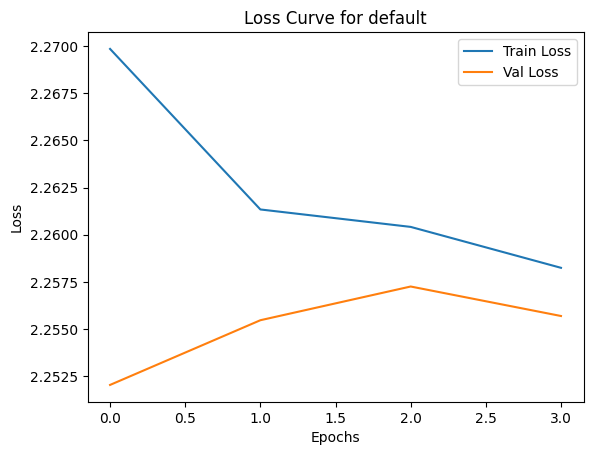

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
Accuracy: 0.12484793187347931
F1 Score (macro): 0.028001750552004566

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.99      0.22       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.28      0.03      0.06       776
           6       0.00      0.00      0.00       324
           7       0.00      0.00      0.00       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.12      6576
   macro avg       0.04      0.10      0.03      6576
weighted avg       0.05      0.12      0.03      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [10]:
default = build_and_train_LSTM_model(model_name="default")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 200, 256)       │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,738 (3.15 MB)

 Trainable params: 825,738 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 169s 488ms/step - accuracy: 0.1143 - loss: 2.3046 - val_accuracy: 0.0937 - val_loss: 2.2687 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 161s 475ms/step - accuracy: 0.1247 - loss: 2.2639 - val_accuracy: 0.0937 - val_loss: 2.2611 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 155s 457ms/step - accuracy: 0.1182 - loss: 2.2648 - val_accuracy: 0.0937 - val_loss: 2.2629 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 162s 477ms/step - accuracy: 0.1252 - loss: 2.2605 - val_accuracy: 0.0937 - val_loss: 2.2590 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 162s 478ms/step - accuracy: 0.1271 - loss: 2.2612 - val_accuracy: 0.0937 - val_loss: 2.2570 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 157s 462ms/step - accuracy: 0.1174 - loss: 2.2639 - val_accuracy: 0.0937 - val_loss: 2.2583 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 165s 487ms/step -

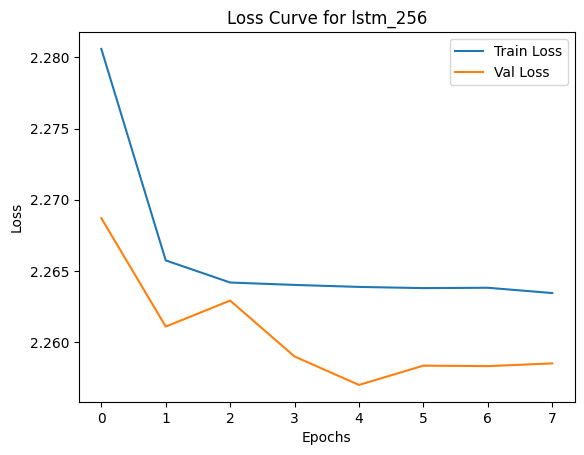

206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step
Accuracy: 0.09367396593673966
F1 Score (macro): 0.017130144605116797

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.00      0.00      0.00       776
           6       0.00      0.00      0.00       324
           7       0.09      1.00      0.17       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.09      6576
   macro avg       0.01      0.10      0.02      6576
weighted avg       0.01      0.09      0.02      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [11]:
lstm_256 =build_and_train_LSTM_model(model_name="lstm_256", lstm_units=256)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 200, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,042 (234.54 KB)

 Trainable params: 60,042 (234.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.1175 - loss: 2.2752 - val_accuracy: 0.1043 - val_loss: 2.2177 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.1440 - loss: 2.2266 - val_accuracy: 0.1693 - val_loss: 2.1772 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.1752 - loss: 2.1782 - val_accuracy: 0.1965 - val_loss: 2.1410 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.1850 - loss: 2.1782 - val_accuracy: 0.1919 - val_loss: 2.1463 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.1822 - loss: 2.1753 - val_accuracy: 0.1910 - val_loss: 2.1447 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.1797 - loss: 2.1775 - val_accuracy: 0.1902 - val_loss: 2.1371 - learning_rate: 5.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - ac

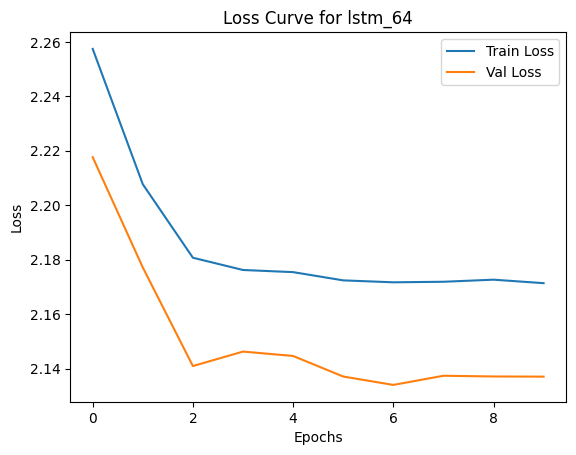

206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Accuracy: 0.1972323600973236
F1 Score (macro): 0.08447668876680595

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.22      0.59      0.32       800
           4       0.17      0.29      0.21       800
           5       0.19      0.76      0.31       776
           6       0.00      0.00      0.00       324
           7       0.00      0.00      0.00       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.20      6576
   macro avg       0.06      0.16      0.08      6576
weighted avg       0.07      0.20      0.10      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [12]:
lstm_64 = build_and_train_LSTM_model(model_name="lstm_64", lstm_units=64)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 86s 242ms/step - accuracy: 0.1118 - loss: 2.2767 - val_accuracy: 0.0991 - val_loss: 2.2602 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 77s 227ms/step - accuracy: 0.1180 - loss: 2.2683 - val_accuracy: 0.0932 - val_loss: 2.2617 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 78s 230ms/step - accuracy: 0.1255 - loss: 2.2632 - val_accuracy: 0.0932 - val_loss: 2.2626 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 83s 245ms/step - accuracy: 0.1260 - loss: 2.2631 - val_accuracy: 0.0932 - val_loss: 2.2616 - learning_rate: 5.0000e-04


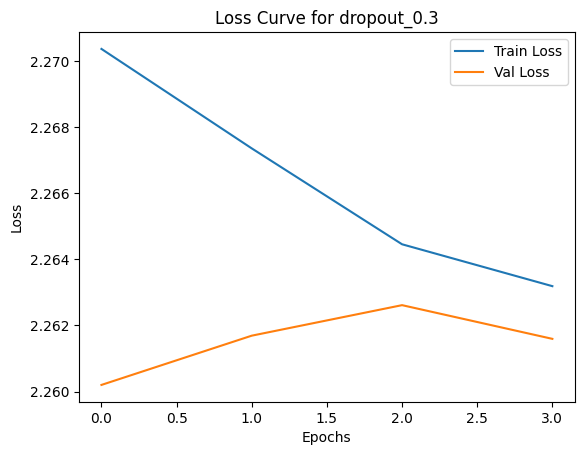

206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step
Accuracy: 0.09914841849148419
F1 Score (macro): 0.025398813989015983

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.28      0.05      0.08       776
           6       0.00      0.00      0.00       324
           7       0.10      1.00      0.17       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.10      6576
   macro avg       0.04      0.10      0.03      6576
weighted avg       0.04      0.10      0.03      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [13]:
dropout_03 =build_and_train_LSTM_model(model_name="dropout_0.3", dropout_rate=0.3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 95s 268ms/step - accuracy: 0.1167 - loss: 2.2758 - val_accuracy: 0.0937 - val_loss: 2.2653 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 89s 263ms/step - accuracy: 0.1171 - loss: 2.2668 - val_accuracy: 0.1180 - val_loss: 2.2595 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 87s 256ms/step - accuracy: 0.1181 - loss: 2.2644 - val_accuracy: 0.0937 - val_loss: 2.2603 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 88s 258ms/step - accuracy: 0.1214 - loss: 2.2611 - val_accuracy: 0.0937 - val_loss: 2.2583 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 87s 256ms/step - accuracy: 0.1224 - loss: 2.2632 - val_accuracy: 0.0937 - val_loss: 2.2598 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 88s 258ms/step - accuracy: 0.1231 - loss: 2.2621 - val_accuracy: 0.0937 - val_loss: 2.2596 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 87s 257ms/step - accura

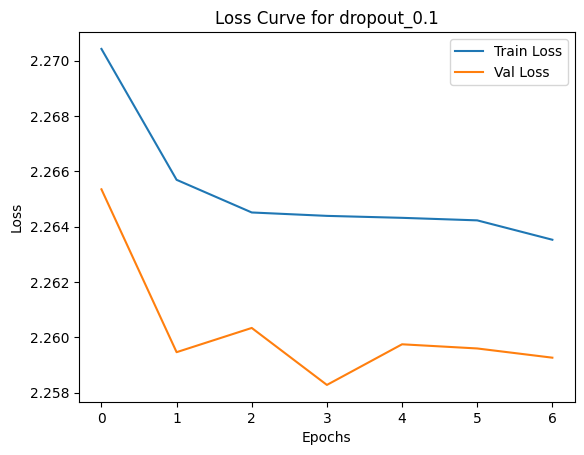

206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step
Accuracy: 0.09367396593673966
F1 Score (macro): 0.017130144605116797

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.00      0.00      0.00       776
           6       0.00      0.00      0.00       324
           7       0.09      1.00      0.17       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.09      6576
   macro avg       0.01      0.10      0.02      6576
weighted avg       0.01      0.09      0.02      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [14]:
dropout_01 = build_and_train_LSTM_model(model_name="dropout_0.1", dropout_rate=0.1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 94s 269ms/step - accuracy: 0.1193 - loss: 2.2763 - val_accuracy: 0.1556 - val_loss: 2.2518 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 273ms/step - accuracy: 0.1636 - loss: 2.2041 - val_accuracy: 0.2480 - val_loss: 2.0550 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 92s 271ms/step - accuracy: 0.2350 - loss: 2.0621 - val_accuracy: 0.2559 - val_loss: 2.0196 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 272ms/step - accuracy: 0.2721 - loss: 1.9318 - val_accuracy: 0.1875 - val_loss: 2.1275 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 92s 272ms/step - accuracy: 0.2427 - loss: 1.9970 - val_accuracy: 0.3405 - val_loss: 1.8008 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 91s 268ms/step - accuracy: 0.3321 - loss: 1.7226 - val_accuracy: 0.3647 - val_loss: 1.7731 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 272ms/step - accura

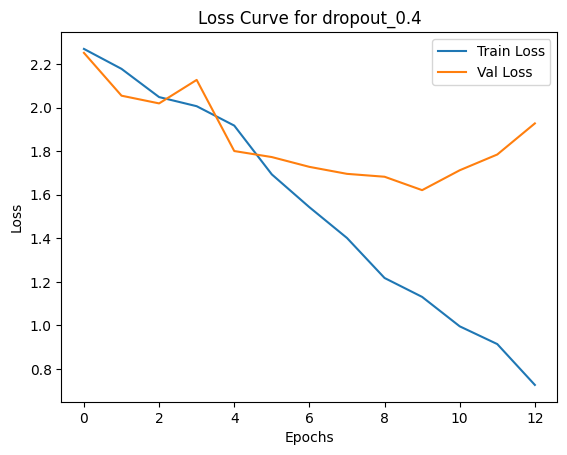

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step
Accuracy: 0.48175182481751827
F1 Score (macro): 0.4557648543543008

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.13      0.17       800
           1       0.16      0.14      0.15       232
           2       0.48      0.31      0.38       800
           3       0.58      0.67      0.62       800
           4       0.53      0.49      0.51       800
           5       0.42      0.39      0.41       776
           6       0.69      0.49      0.57       324
           7       0.62      0.82      0.71       616
           8       0.50      0.59      0.54       628
           9       0.41      0.65      0.50       800

    accuracy                           0.48      6576
   macro avg       0.46      0.47      0.46      6576
weighted avg       0.47      0.48      0.46      6576



In [15]:
dropout_04 = build_and_train_LSTM_model(model_name="dropout_0.4", dropout_rate=0.4)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 102s 291ms/step - accuracy: 0.1144 - loss: 2.6039 - val_accuracy: 0.0937 - val_loss: 2.2708 - learning_rate: 0.0500
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 95s 280ms/step - accuracy: 0.1172 - loss: 2.2652 - val_accuracy: 0.0937 - val_loss: 2.2643 - learning_rate: 0.0500
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 95s 278ms/step - accuracy: 0.1181 - loss: 2.2678 - val_accuracy: 0.1217 - val_loss: 2.2634 - learning_rate: 0.0500
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 97s 286ms/step - accuracy: 0.1124 - loss: 2.2673 - val_accuracy: 0.1217 - val_loss: 2.2609 - learning_rate: 0.0500
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 96s 284ms/step - accuracy: 0.1183 - loss: 2.2648 - val_accuracy: 0.1217 - val_loss: 2.2625 - learning_rate: 0.0500
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 96s 282ms/step - accuracy: 0.1198 - loss: 2.2681 - val_accuracy: 0.1217 - val_loss: 2.2602 - learning_rate: 0.0500
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 97s 285ms/step - accur

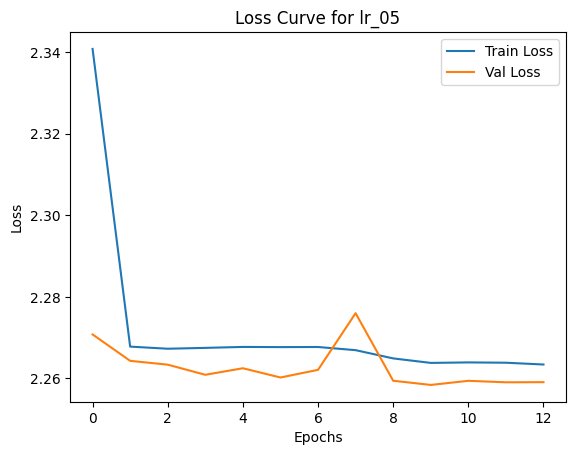

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Accuracy: 0.09367396593673966
F1 Score (macro): 0.017130144605116797

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.00      0.00      0.00       776
           6       0.00      0.00      0.00       324
           7       0.09      1.00      0.17       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.09      6576
   macro avg       0.01      0.10      0.02      6576
weighted avg       0.01      0.09      0.02      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [16]:
lr_05 =build_and_train_LSTM_model(model_name="lr_05", learning_rate=0.05)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 111s 317ms/step - accuracy: 0.1630 - loss: 2.1859 - val_accuracy: 0.2080 - val_loss: 2.0179 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 100s 295ms/step - accuracy: 0.2189 - loss: 2.0382 - val_accuracy: 0.2191 - val_loss: 2.0401 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 272ms/step - accuracy: 0.2249 - loss: 2.0271 - val_accuracy: 0.2103 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 94s 277ms/step - accuracy: 0.2557 - loss: 1.9781 - val_accuracy: 0.2754 - val_loss: 1.9306 - learning_rate: 1.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 100s 295ms/step - accuracy: 0.2859 - loss: 1.8901 - val_accuracy: 0.3168 - val_loss: 1.8588 - learning_rate: 1.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 100s 294ms/step - accuracy: 0.3103 - loss: 1.8322 - val_accuracy: 0.3384 - val_loss: 1.8094 - learning_rate: 1.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 99s 290

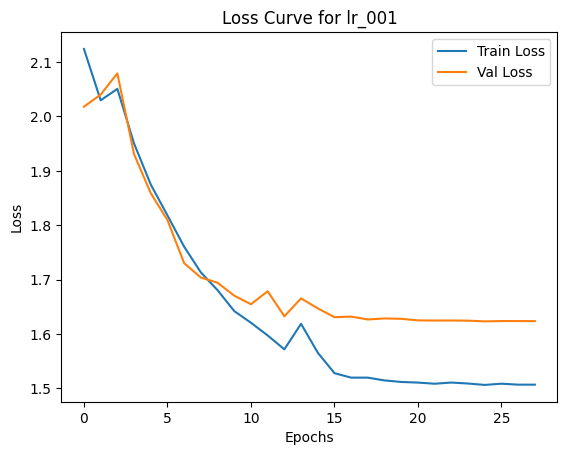

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Accuracy: 0.41058394160583944
F1 Score (macro): 0.38637804661853475

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.42      0.37       800
           1       0.29      0.05      0.09       232
           2       0.37      0.30      0.33       800
           3       0.67      0.50      0.57       800
           4       0.70      0.38      0.49       800
           5       0.25      0.13      0.17       776
           6       0.45      0.76      0.56       324
           7       0.38      0.73      0.50       616
           8       0.31      0.60      0.41       628
           9       0.48      0.31      0.38       800

    accuracy                           0.41      6576
   macro avg       0.42      0.42      0.39      6576
weighted avg       0.44      0.41      0.40      6576



In [17]:
lr_001 = build_and_train_LSTM_model(model_name="lr_001", learning_rate=0.001)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 109s 310ms/step - accuracy: 0.1186 - loss: 2.2859 - val_accuracy: 0.1513 - val_loss: 2.2431 - learning_rate: 0.0100
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 97s 286ms/step - accuracy: 0.1832 - loss: 2.1791 - val_accuracy: 0.2648 - val_loss: 1.9621 - learning_rate: 0.0100
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - accuracy: 0.3074 - loss: 1.9049 - val_accuracy: 0.3552 - val_loss: 1.7900 - learning_rate: 0.0100
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 98s 290ms/step - accuracy: 0.4222 - loss: 1.6190 - val_accuracy: 0.3394 - val_loss: 1.8019 - learning_rate: 0.0100
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 97s 284ms/step - accuracy: 0.4162 - loss: 1.6406 - val_accuracy: 0.4182 - val_loss: 1.6785 - learning_rate: 0.0100
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 98s 288ms/step - accuracy: 0.5140 - loss: 1.3922 - val_accuracy: 0.4501 - val_loss: 1.6342 - learning_rate: 0.0100
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 97s 286ms/step - accur

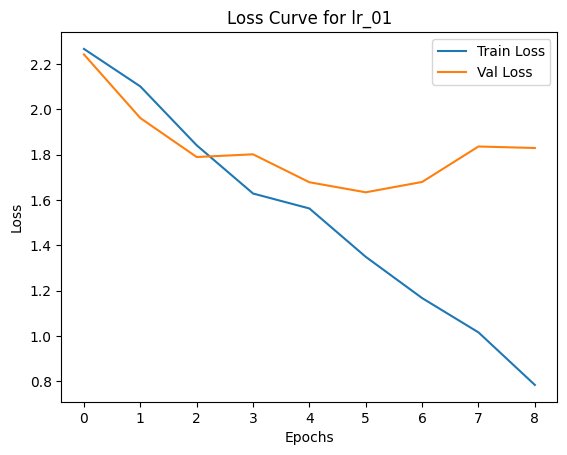

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Accuracy: 0.45012165450121655
F1 Score (macro): 0.4702273670234328

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.33      0.30       800
           1       0.34      0.48      0.40       232
           2       0.39      0.49      0.43       800
           3       0.63      0.54      0.58       800
           4       0.64      0.48      0.55       800
           5       0.28      0.26      0.27       776
           6       0.94      0.63      0.75       324
           7       0.57      0.73      0.64       616
           8       0.44      0.47      0.45       628
           9       0.39      0.29      0.33       800

    accuracy                           0.45      6576
   macro avg       0.49      0.47      0.47      6576
weighted avg       0.47      0.45      0.45      6576



In [18]:
lr_01 = build_and_train_LSTM_model(model_name="lr_01", learning_rate=0.01)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.1216 - loss: 2.2692 - val_accuracy: 0.0996 - val_loss: 2.2291 - learning_rate: 0.0050
Epoch 2/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 108s 159ms/step - accuracy: 0.1248 - loss: 2.2561 - val_accuracy: 0.0985 - val_loss: 2.2389 - learning_rate: 0.0050
Epoch 3/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 121s 178ms/step - accuracy: 0.1267 - loss: 2.2542 - val_accuracy: 0.1001 - val_loss: 2.2433 - learning_rate: 0.0050
Epoch 4/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 125s 184ms/step - accuracy: 0.1294 - loss: 2.2536 - val_accuracy: 0.0999 - val_loss: 2.2442 - learning_rate: 5.0000e-04


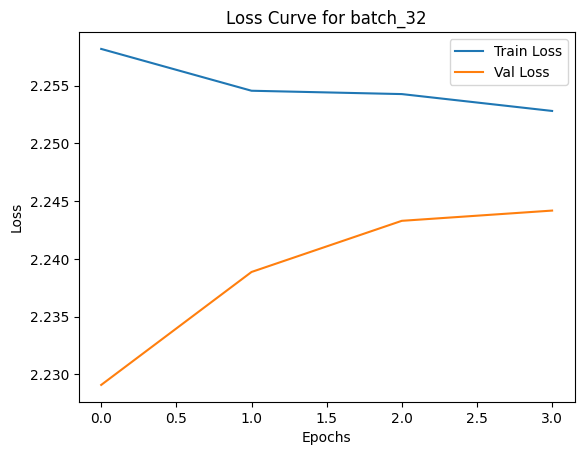

206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step
Accuracy: 0.09960462287104623
F1 Score (macro): 0.025393940559119386

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.19      0.05      0.08       800
           4       0.00      0.00      0.00       800
           5       0.00      0.00      0.00       776
           6       0.00      0.00      0.00       324
           7       0.10      1.00      0.18       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.10      6576
   macro avg       0.03      0.10      0.03      6576
weighted avg       0.03      0.10      0.03      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [19]:
batch_32 = build_and_train_LSTM_model(model_name="batch_32", batch_size=32)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,970 (847.54 KB)

 Trainable params: 216,970 (847.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 158s 906ms/step - accuracy: 0.1221 - loss: 2.2643 - val_accuracy: 0.1340 - val_loss: 2.2274 - learning_rate: 0.0050
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 149s 877ms/step - accuracy: 0.1207 - loss: 2.2441 - val_accuracy: 0.0923 - val_loss: 2.2441 - learning_rate: 0.0050
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 142s 834ms/step - accuracy: 0.1240 - loss: 2.2404 - val_accuracy: 0.0929 - val_loss: 2.2363 - learning_rate: 0.0050
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 154s 907ms/step - accuracy: 0.1299 - loss: 2.2443 - val_accuracy: 0.1026 - val_loss: 2.2343 - learning_rate: 5.0000e-04


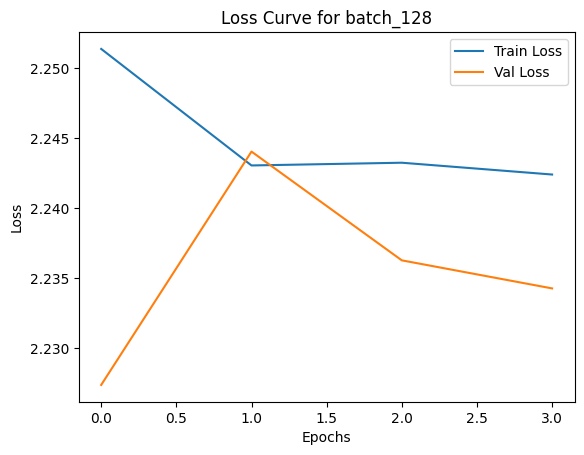

206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step
Accuracy: 0.1339720194647202
F1 Score (macro): 0.05533875632797949

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.12      0.99      0.22       776
           6       0.32      0.35      0.33       324
           7       0.00      0.00      0.00       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.13      6576
   macro avg       0.04      0.13      0.06      6576
weighted avg       0.03      0.13      0.04      6576



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [22]:
batch_128 = build_and_train_LSTM_model(model_name="batch_128", batch_size=128)

# best models till now were lr_001, lr_01 and dropout_04

In [23]:
best_model = dropout_04

In [ ]:
#evaluate_model(best_model, X_test, y_test)

In [ ]:
#plot_conf_matrix(best_model, X_test, y_test, class_names)


In [24]:
evaluate_model(best_model, X_val, y_val)

AttributeError: 'tuple' object has no attribute 'predict'

In [25]:
plot_conf_matrix(best_model, X_val, y_val)  

AttributeError: 'tuple' object has no attribute 'predict'

In [31]:
# ==== New Default Hyperparameters ====
INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 128
DROPOUT_RATE = 0.5
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PROJECTION_DIM = 32
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 200, 32)        │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 200, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,946 (906.04 KB)

 Trainable params: 231,946 (906.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 248s 701ms/step - accuracy: 0.1355 - loss: 2.2423 - val_accuracy: 0.1992 - val_loss: 2.1723 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 225s 661ms/step - accuracy: 0.1592 - loss: 2.2112 - val_accuracy: 0.1627 - val_loss: 2.2386 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 218s 642ms/step - accuracy: 0.1587 - loss: 2.2098 - val_accuracy: 0.2231 - val_loss: 2.0752 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 219s 644ms/step - accuracy: 0.1902 - loss: 2.1398 - val_accuracy: 0.2556 - val_loss: 2.0646 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 218s 641ms/step - accuracy: 0.2332 - loss: 2.0151 - val_accuracy: 0.2619 - val_loss: 1.9669 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 214s 631ms/step - accuracy: 0.2805 - loss: 1.8954 - val_accuracy: 0.2906 - val_loss: 1.8858 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 216s 635ms/step -

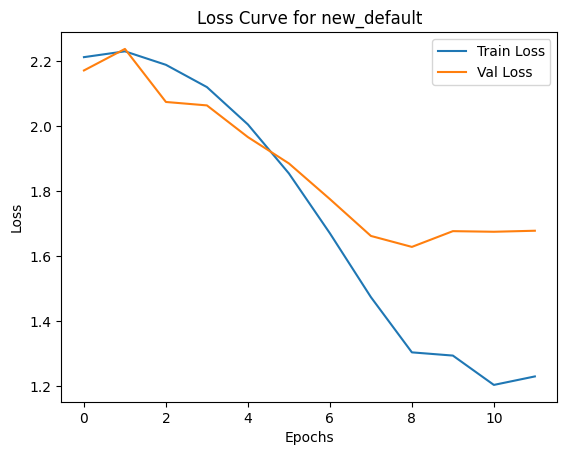

206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step
Accuracy: 0.4642639902676399
F1 Score (macro): 0.4786480948702153

Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.41      0.35       800
           1       0.47      0.40      0.43       232
           2       0.40      0.33      0.36       800
           3       0.87      0.54      0.66       800
           4       0.51      0.50      0.51       800
           5       0.37      0.25      0.30       776
           6       0.73      0.69      0.71       324
           7       0.43      0.58      0.49       616
           8       0.50      0.47      0.48       628
           9       0.43      0.59      0.50       800

    accuracy                           0.46      6576
   macro avg       0.50      0.47      0.48      6576
weighted avg       0.49      0.46      0.47      6576



In [32]:
new_default = build_and_train_LSTM_model(model_name="new_default")

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 200, 64)        │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,458 (970.54 KB)

 Trainable params: 248,458 (970.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 162s 452ms/step - accuracy: 0.1366 - loss: 2.2501 - val_accuracy: 0.2207 - val_loss: 2.1516 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.1900 - loss: 2.1191 - val_accuracy: 0.2400 - val_loss: 1.9996 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 432ms/step - accuracy: 0.2472 - loss: 2.0035 - val_accuracy: 0.2898 - val_loss: 1.8879 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 148s 435ms/step - accuracy: 0.2936 - loss: 1.8735 - val_accuracy: 0.3554 - val_loss: 1.8624 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 149s 437ms/step - accuracy: 0.3772 - loss: 1.6573 - val_accuracy: 0.3821 - val_loss: 1.7237 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 431ms/step - accuracy: 0.4669 - loss: 1.4503 - val_accuracy: 0.4191 - val_loss: 1.7509 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 433ms/step -

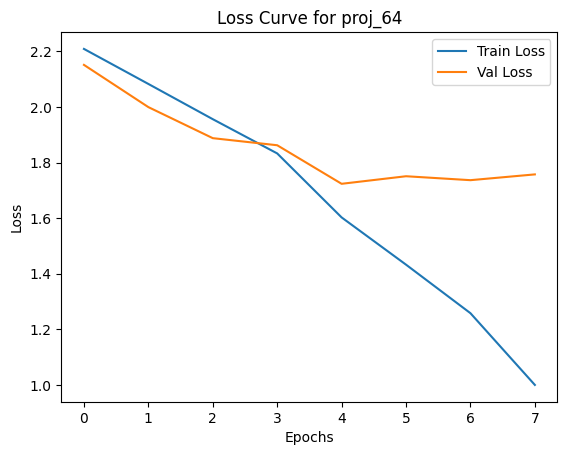

206/206 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step
Accuracy: 0.382147201946472
F1 Score (macro): 0.36472256835841776

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.39      0.31       800
           1       0.45      0.06      0.11       232
           2       0.32      0.23      0.27       800
           3       0.68      0.54      0.60       800
           4       0.44      0.54      0.49       800
           5       0.22      0.09      0.12       776
           6       0.60      0.77      0.67       324
           7       0.35      0.60      0.44       616
           8       0.28      0.49      0.35       628
           9       0.56      0.18      0.28       800

    accuracy                           0.38      6576
   macro avg       0.42      0.39      0.36      6576
weighted avg       0.41      0.38      0.36      6576



In [33]:
PROJ_64 = build_and_train_LSTM_model(model_name="proj_64", projection_dim=64)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 200, 16)        │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 200, 128)       │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,690 (873.79 KB)

 Trainable params: 223,690 (873.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 219s 618ms/step - accuracy: 0.1510 - loss: 2.2209 - val_accuracy: 0.1922 - val_loss: 2.1431 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 206s 607ms/step - accuracy: 0.2245 - loss: 2.0593 - val_accuracy: 0.2343 - val_loss: 2.0615 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 205s 604ms/step - accuracy: 0.2426 - loss: 2.0011 - val_accuracy: 0.2825 - val_loss: 1.9261 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 210s 619ms/step - accuracy: 0.2913 - loss: 1.8143 - val_accuracy: 0.2841 - val_loss: 1.8646 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 209s 614ms/step - accuracy: 0.3183 - loss: 1.7654 - val_accuracy: 0.3432 - val_loss: 1.7754 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 211s 622ms/step - accuracy: 0.3690 - loss: 1.6454 - val_accuracy: 0.3575 - val_loss: 1.7621 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 212s 624ms/step -

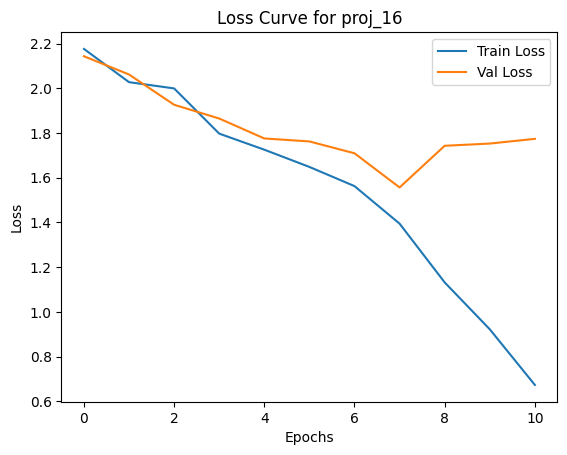

206/206 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step
Accuracy: 0.5054744525547445
F1 Score (macro): 0.4954136742213879

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.28      0.31       800
           1       0.50      0.13      0.21       232
           2       0.49      0.39      0.43       800
           3       0.72      0.66      0.69       800
           4       0.50      0.62      0.55       800
           5       0.55      0.25      0.34       776
           6       0.92      0.77      0.84       324
           7       0.38      0.75      0.50       616
           8       0.54      0.52      0.53       628
           9       0.47      0.63      0.54       800

    accuracy                           0.51      6576
   macro avg       0.54      0.50      0.50      6576
weighted avg       0.52      0.51      0.49      6576



In [34]:
PROJ_16 = build_and_train_LSTM_model(model_name="proj_16", projection_dim=16)